-5.500331222045079


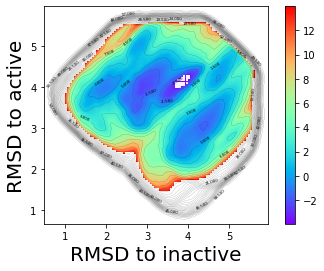

In [3]:

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Feb 21 17:30:07 2019

@author: keshavpatil
"""

# This code reads the fes.dat file generated by PLUMED 
# and plots the free energy landscape and also outputs the free energy of the zone of interest at 2.4 microsecond
# implementing the equation number 4 in SI of Patil et. al. PNAS 2021 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


with open('fes_600.dat') as f:
    
    lines = f.readlines()
    
    
    
#lines = lines[9:2659]

new_lines = []    
# Get rid of empty lines
for line in lines:
    # Strip whitespace, should leave nothing if empty line was just "\n"
    if not line.strip():
        continue
    # We got something, save it
    else:
        new_lines.append(line)
        
lines = new_lines[9:]
    
bin_size_active = 101 # This was set in the PLUMED simulation
bin_size_inactive = 101
x = []
y1 = [] # stores the inactive coordinates
y2 = [] # stores the active coordinates
z1 = []
z = np.zeros((1,bin_size_inactive))
for i in range(0,len(lines)):
    
    words = lines[i].split()
    int_lst = [float(x) for x in words]
   
    y1.append(int_lst[0]) #y1 takes in inactive rmsd coordinates
    y2.append(int_lst[1]) #y2 takes in active rmsd coordinates
    z1.append(int_lst[2])  #z takes the free energy
 
            
y1 = np.array(y1)
y2 = np.array(y2)

y1 = y1[0:bin_size_inactive]
y2 = y2[0:len(lines):bin_size_inactive]
j = 1


# making a 2-D matrix z
for i in range(0,len(z1),bin_size_inactive):
    z = np.r_[z,[z1[i:i+bin_size_inactive]]] 


# deleting the first row of all zeros in z
z = np.delete(z, (0), axis=0)


x,y = np.meshgrid(y1,y2)


# We take the coordinates (3,4) as reference
# More correctly, we take the bin number [46][63] as our
# references in all the profiles, and this consistent in all landscapes.
# The other and much better alternative would be to to set all the profiles to a minimum of Free energy=0. 
# It doesn't matter as free energies are relative. 
z = z - z[46][63]

x_c_set = []
y_c_set = []



# This range of i and j were determined in order to fine-cut the zone of interest on the landscape. 
for i in range(58+1,67):
    bin_width = (y1[-1] - y1[0]) / bin_size_inactive
    x_c = y1[0] + (i) * bin_width
    x_c_set.append(x_c)

for j in range(61+1,69):
    bin_width = (y1[-1] - y1[0]) / bin_size_inactive
    y_c = y2[0] + (j-1) * bin_width
    y_c_set.append(y_c)



zz = np.array([i[58+1:67] for i in z[61+1:69]])

# that particular zone
x11,y11 = np.meshgrid(x_c_set,y_c_set)

#getting the particular region within that "zone" which is below 0 Kcal/mol
zzz = np.ma.masked_where((-3 >= zz), zz)
q = np.where(zzz.mask)

x_c_subset = []
y_c_subset = []


  
for u in range(0,len(q[1])):
    r = q[0][u]
    c = q[1][u]
    x_c_subset.append(x11[r][c])
    y_c_subset.append(y11[r][c])
    

      
y_c_subset = np.array(y_c_subset)    
x_c_subset = np.array(x_c_subset)
plt.scatter(x_c_subset, y_c_subset, s=1, color='white',marker='s')
 
# computing the free energy of the state: F_st = -(1/beta)log (Σ exp(-beta F(x,y)))
# beta = 1/K_b T = 1/0.6 = 1.66
sum_exp = 0.0

for i in range(0,zz.shape[0]):
    for j in range(0,zz.shape[1]):
        if zz[i][j] <= -3:
            sum_exp = sum_exp + np.exp(-1.66 * zz[i][j])
            
F_st = -(0.6) * np.log(sum_exp)

print(F_st)
        
# masking the overall matrix z 
                            
contours = plt.contour(y1, y2, z, 50, colors='black',linewidths=0.1)
z =np.ma.masked_where((14 < z) & (z < 100), z)
plt.clabel(contours, inline=True, fontsize=4)
plt.imshow(z, extent=[min(y1), max(y1), min(y2), max(y2)], origin='lower',
          cmap='rainbow')#,ylabel='kkk')
plt.clim(z.min(),z.max())
plt.colorbar()
          
        

plt.xlabel('RMSD to inactive',fontsize=20)
plt.ylabel('RMSD to active',fontsize=20)


plt.savefig('HILLS_section_2.png', bbox_inches = 'tight', dpi = 300)

plt.show()


x_bin_number = []
y_bin_number = []
for i in range(0,len(x_c_subset)):
    x_bin_num = np.math.ceil((x_c_subset[i] - y1[0])/bin_width)
    x_bin_number.append(x_bin_num)
    
for i in range(0,len(y_c_subset)):
    y_bin_num = np.math.ceil((y_c_subset[i] - y2[0])/bin_width)
    y_bin_number.append(y_bin_num)


x_c_subset_bin = np.array(x_bin_number)
y_c_subset_bin = np.array(y_bin_number)
np.savetxt('x_c_subset_bin_zone2.txt', x_c_subset_bin)
np.savetxt('y_c_subset_bin_zone2.txt', y_c_subset_bin)